In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('../resources/custom_style.mplstyle')

from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

Creating custom cmap based on League of Legends color palette

In [92]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

N = 256
vals = np.ones((N,4))
vals[:, 0] = np.linspace(58/256, 240/256, N)
vals[:, 1] = np.linspace(120/256, 222/256, N)
vals[:, 2] = np.linspace(117/256, 147/256, N)
newcmp = ListedColormap(vals)

# EDA

In [3]:
df = pd.read_csv('2021_matches.csv')
pd.set_option('display.max_columns', None)
df.head()

gameid datacompleteness  \
0  ESPORTSTMNT03/1632489         complete   
1  ESPORTSTMNT03/1632489         complete   
2  ESPORTSTMNT03/1632489         complete   
3  ESPORTSTMNT03/1632489         complete   
4  ESPORTSTMNT03/1632489         complete   

                                                 url league  year split  \
0  http://matchhistory.na.leagueoflegends.com/en/...  KeSPA  2021   NaN   
1  http://matchhistory.na.leagueoflegends.com/en/...  KeSPA  2021   NaN   
2  http://matchhistory.na.leagueoflegends.com/en/...  KeSPA  2021   NaN   
3  http://matchhistory.na.leagueoflegends.com/en/...  KeSPA  2021   NaN   
4  http://matchhistory.na.leagueoflegends.com/en/...  KeSPA  2021   NaN   

   playoffs                 date  game  patch  playerid  side position  \
0         0  2021-01-02 07:40:39     1  10.25         1  Blue      top   
1         0  2021-01-02 07:40:39     1  10.25         2  Blue      jng   
2         0  2021-01-02 07:40:39     1  10.25         3  Blue      mid   
3         0  2021-01-02 07:40:39     1  10.25         4  Blue      bot   
4         0  2021-01-02 07:40:39     1  10.25         5  Blue      sup   

      player     team      champion    ban1    ban2      ban3      ban4  \
0       Khan  DWG KIA   Mordekaiser  Aatrox  Kai'Sa  Pantheon  Aphelios   
1     Canyon  DWG KIA        Graves  Aatrox  Kai'Sa  Pantheon  Aphelios   
2  ShowMaker  DWG KIA           Zoe  Aatrox  Kai'Sa  Pantheon  Aphelios   
3      Ghost  DWG KIA  Miss Fortune  Aatrox  Kai'Sa  Pantheon  Aphelios   
4      BeryL  DWG KIA         Galio  Aatrox  Kai'Sa  Pantheon  Aphelios   

     ban5  gamelength  result  kills  deaths  assists  teamkills  teamdeaths  \
0  Lucian        1782       1      7       1        3         23           4   
1  Lucian        1782       1      7       1        5         23           4   
2  Lucian        1782       1      5       0        8         23           4   
3  Lucian        1782       1      3       2       11         23           4   
4  Lucian        1782       1      1       0       14         23           4   

   doublekills  triplekills  quadrakills  pentakills  firstblood  \
0          0.0          0.0          0.0         0.0         1.0   
1          0.0          0.0          0.0         0.0         0.0   
2          1.0          0.0          0.0         0.0         0.0   
3          0.0          0.0          0.0         0.0         0.0   
4          0.0          0.0          0.0         0.0         0.0   

   firstbloodkill  firstbloodassist  firstbloodvictim  team kpm    ckpm  \
0             1.0               0.0               0.0    0.7744  0.9091   
1             0.0               0.0               0.0    0.7744  0.9091   
2             0.0               0.0               0.0    0.7744  0.9091   
3             0.0               0.0               0.0    0.7744  0.9091   
4             0.0               0.0               0.0    0.7744  0.9091   

   firstdragon  dragons  opp_dragons  elementaldrakes  opp_elementaldrakes  \
0          NaN      NaN          NaN              NaN                  NaN   
1          NaN      NaN          NaN              NaN                  NaN   
2          NaN      NaN          NaN              NaN                  NaN   
3          NaN      NaN          NaN              NaN                  NaN   
4          NaN      NaN          NaN              NaN                  NaN   

   infernals  mountains  clouds  oceans  dragons (type unknown)  elders  \
0        NaN        NaN     NaN     NaN                     NaN     NaN   
1        NaN        NaN     NaN     NaN                     NaN     NaN   
2        NaN        NaN     NaN     NaN                     NaN     NaN   
3        NaN        NaN     NaN     NaN                     NaN     NaN   
4        NaN        NaN     NaN     NaN                     NaN     NaN   

   opp_elders  firstherald  heralds  opp_heralds  firstbaron  barons  \
0         NaN          NaN      NaN          NaN         NaN     Na

### Added death_adj field to prevent divide by zero issues for KDA calc

In [4]:
df['death_15_adj'] =  df.deathsat15.map(lambda x: 1 if x==0 else x)
df['kda_15'] = (df.killsat15 + df.assistsat15)/df.death_15_adj

### Converted 'side' field to a 1/0

In [5]:
df['side_bool'] = df.side.map(lambda x: 1 if x == 'Blue' else 0)

### Creating KDA by position fields

In [6]:
pos_lst = ['top','jng','mid','bot','sup']

df_teams = df[df.position == 'team'].reset_index()
df_teams['id_side'] = df_teams.gameid + '_' + df_teams.side
df_teams.set_index('id_side')

df_players = df[df.position != 'team']

Created pivoted table of kda by position grouped by the gameid+side; to be joined with the teams dataframe

In [7]:
df_players_piv = df_players[['position','kda_15']].pivot(values ='kda_15',columns = 'position')

df_players_piv['gameid'] = df_players.gameid
df_players_piv['side'] = df_players.side
df_players_piv['id_side'] = df_players_piv.gameid + '_' + df_players_piv.side

df_players_piv = df_players_piv.fillna(0)
df_players_piv.head(10)
df_players_piv = df_players_piv.groupby(['id_side']).sum().reset_index()
df_players_piv.set_index('id_side')

## renames position columns to include the timestamp
df_players_piv.columns = [col + '_15' for col in df_players_piv.columns.values]
df_players_piv.rename({'id_side_15':'id_side'}, axis = 1, inplace = True)

Joined the position pivot onto the teams dataframe on the gameid+side

In [8]:
df_agg = df_teams.set_index('id_side').join(df_players_piv.set_index('id_side'))

## Estimated Fields

### Estimated CS at 15 with linear reg. modeling

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


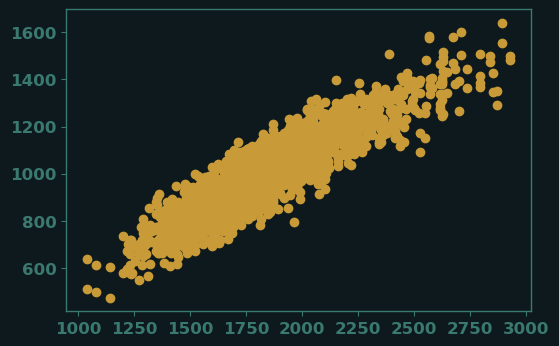

In [9]:
plt.scatter(df_agg['gamelength'],df_agg['total cs'])
#color = newcmp.colors[-1]

In [10]:
lin_reg_cs = LinearRegression()
df_cslr = df_agg[['gamelength','total cs']].dropna()
X_cslr, y_cslr = df_cslr['gamelength'].values.reshape(-1,1), df_cslr['total cs']
lin_reg_cs.fit(X_cslr, y_cslr)

LinearRegression()

In [11]:
lin_reg_cs.coef_

array([0.50879691])

cs @ 15 = [total cs]-([gamelength] - 900)x

Now, because we only have around 2\,000 non-null 'total cs' fields, we use our newly trained linear model to impute values into these null records. From there, we can calculate our estimated cs @ 15 field using our newly imputed total cs field:

In [12]:
#df_agg['total cs'] = (df_agg['gamelength']*lin_reg_cs.coef_) if df_agg['total cs'].isnull() else df_agg['total cs'])
df_agg['total_cs'] = df_agg['total cs'].fillna(df_agg['gamelength']*lin_reg_cs.coef_)
df_agg['csat15_est'] = df_agg['total_cs'] - (df_agg['gamelength']-900)*lin_reg_cs.coef_

### Visualizing features with pairplot

In [13]:
col_lst = ['kda_15','top_15','jng_15','mid_15','bot_15','sup_15',
           'side_bool','result','csdiffat15','killsat15','assistsat15',
           'deathsat15','golddiffat15','xpdiffat15','csat15_est']
df_plot = df_agg[col_lst].dropna()

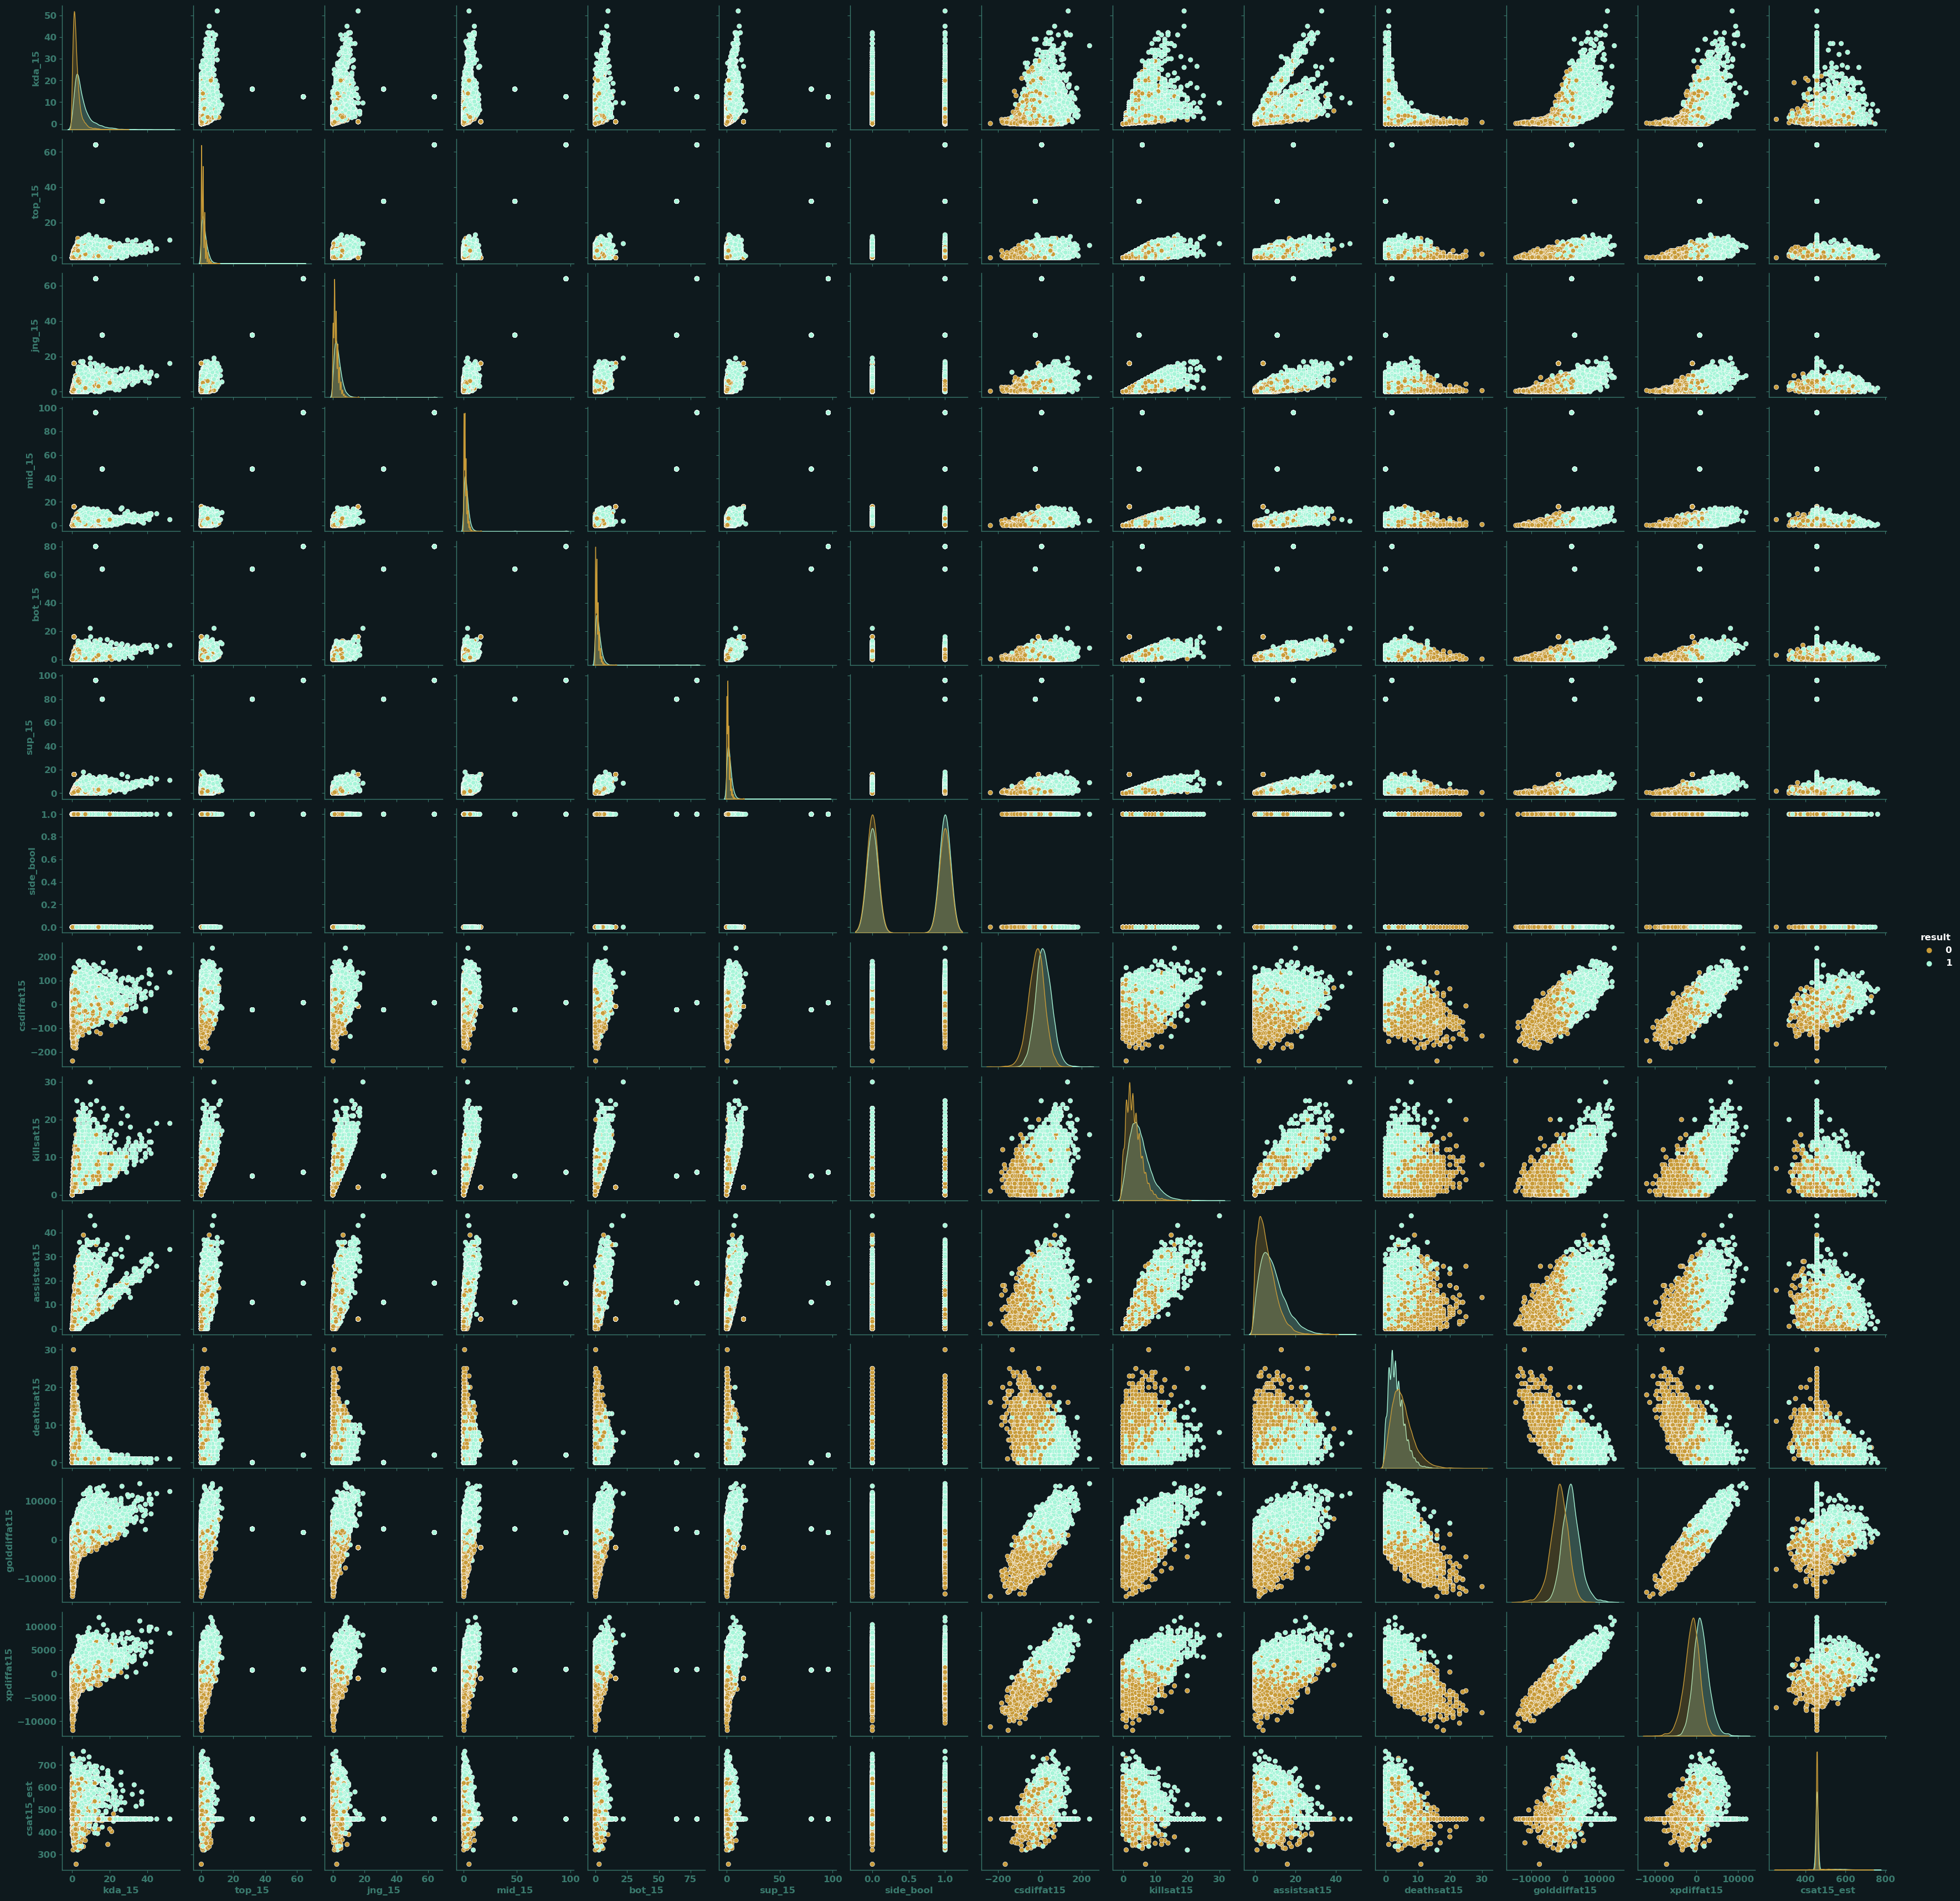

In [99]:
sns.pairplot(df_plot, hue = 'result')

# Modeling

## Training and scoring

First we split our data into training/testing subsets along an 80-20 split:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_plot.drop(columns = 'result'), df_plot['result'],
                                                    test_size = 0.2, random_state=42)

train_df = X_train.copy()
train_df['result'] = y_train

test_df = X_test.copy()
test_df['result'] = y_test

In [15]:
lr = LogisticRegression(max_iter = 1000)

### Cross-validating to tune hyperparameters

In [16]:
c_range = list(range(1,50))
param_grid = dict(C = c_range)

In [17]:
grid = GridSearchCV(lr, param_grid, cv=10, scoring='f1')

In [18]:
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                               27, 28, 29, 30, ...]},
             scoring='f1')

In [19]:
c_best = grid.best_params_['C']

print('Best params: ', c_best)
print('Best score:', grid.best_score_)

Best params:  16
Best score: 0.7589347760464885


### Using tuned parameters to finalize training/score model

In [20]:
lr = LogisticRegression(C = c_best, max_iter = 1000, multi_class = 'multinomial')
lr.fit(X_train,y_train)

LogisticRegression(C=16, max_iter=1000, multi_class='multinomial')

In [89]:
y_pred = lr.predict(X_test)
f1_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.7561669829222012

## Evaluating results using visualization

### Confusion matrix

[[1586  503]
 [ 525 1602]]


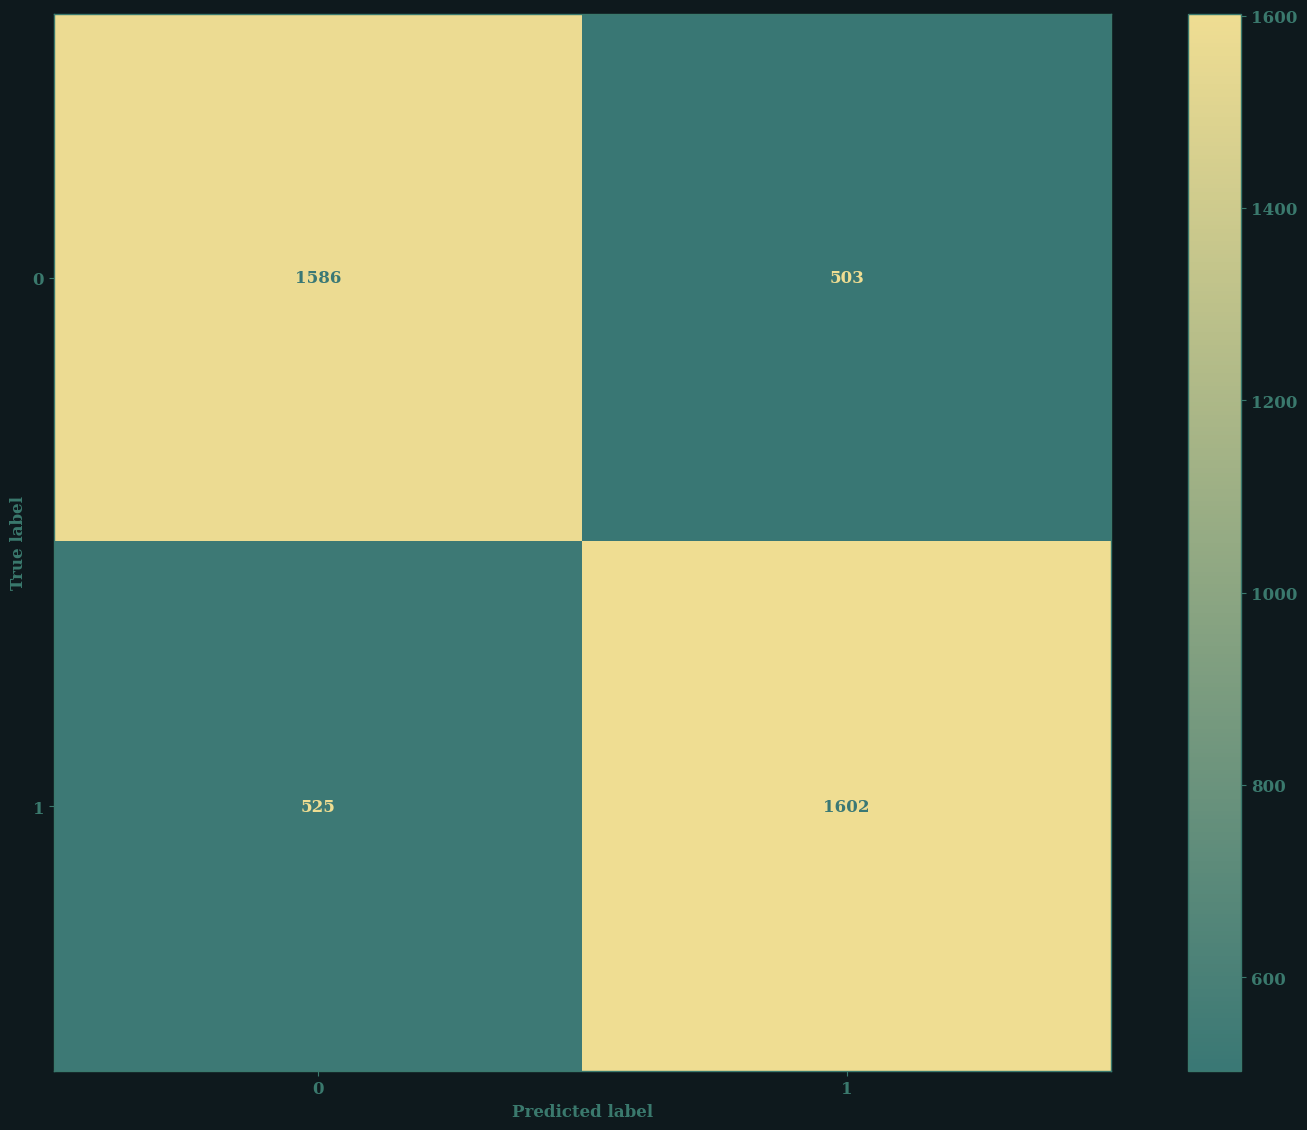

In [93]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(lr, X_test, y_test, cmap = newcmp)
plt.title = 'Confusion Matrix'

### Assessing soft probability predictions

In [26]:
proba = lr.predict_proba(X_train)

proba_test = df['result'].copy()
proba_test['prob'] = proba * 100

In [27]:
win_lst = [match[1]*100 for match in proba]

In [28]:
df_proba = train_df[['result']].copy()
df_proba['pred'] = lr.predict(X_train)
df_proba['prob'] = win_lst

In [29]:
false_pos = []
false_neg = []

for idx,rec in df_proba.iterrows():
    if rec.result == 0:
        false_pos.append(rec.prob)
    else:
        false_neg.append(rec.prob)

def mean(lst):
    return sum(lst)/len(lst)

print(mean(false_pos))
print(mean(false_neg))

32.428611659973775
67.72386116212141


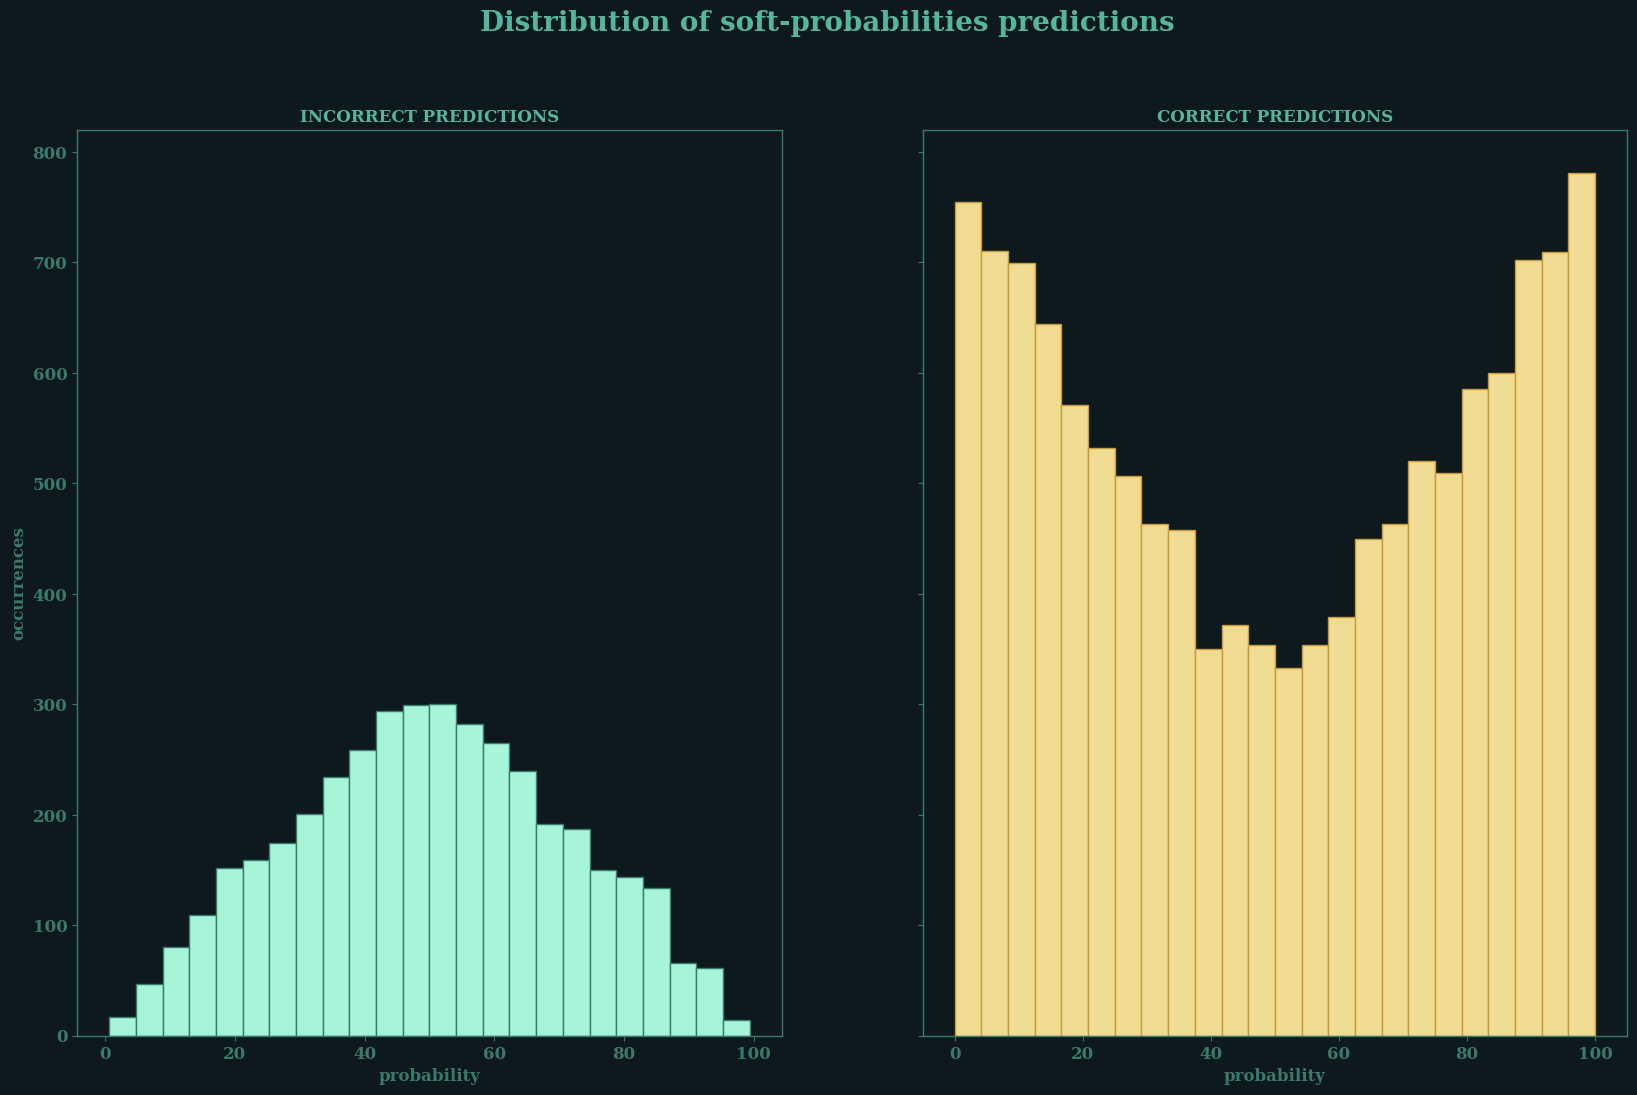

In [98]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey= True)
fig.suptitle('Distribution of soft-probabilities predictions', color = '#55B5A1', fontsize = 20)
ax1.hist(df_proba[(df_proba.result != df_proba.pred)].prob, bins = 24, color = '#A6F5D8',edgecolor = '#3A796D')
ax1.set_xlabel('probability')
ax1.set_ylabel('occurrences')
ax1.set_title('INCORRECT PREDICTIONS')
ax2.hist(df_proba[(df_proba.result == df_proba.pred)].prob, bins = 24,color = '#F0DB92',edgecolor = '#C89B38')
ax2.set_xlabel('probability')
ax2.set_title('CORRECT PREDICTIONS')
fig.set_size_inches(20, 12)

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

ROC AUC score =  0.8445302964933968


Text(0.5, 0.98, 'ROC Curve')

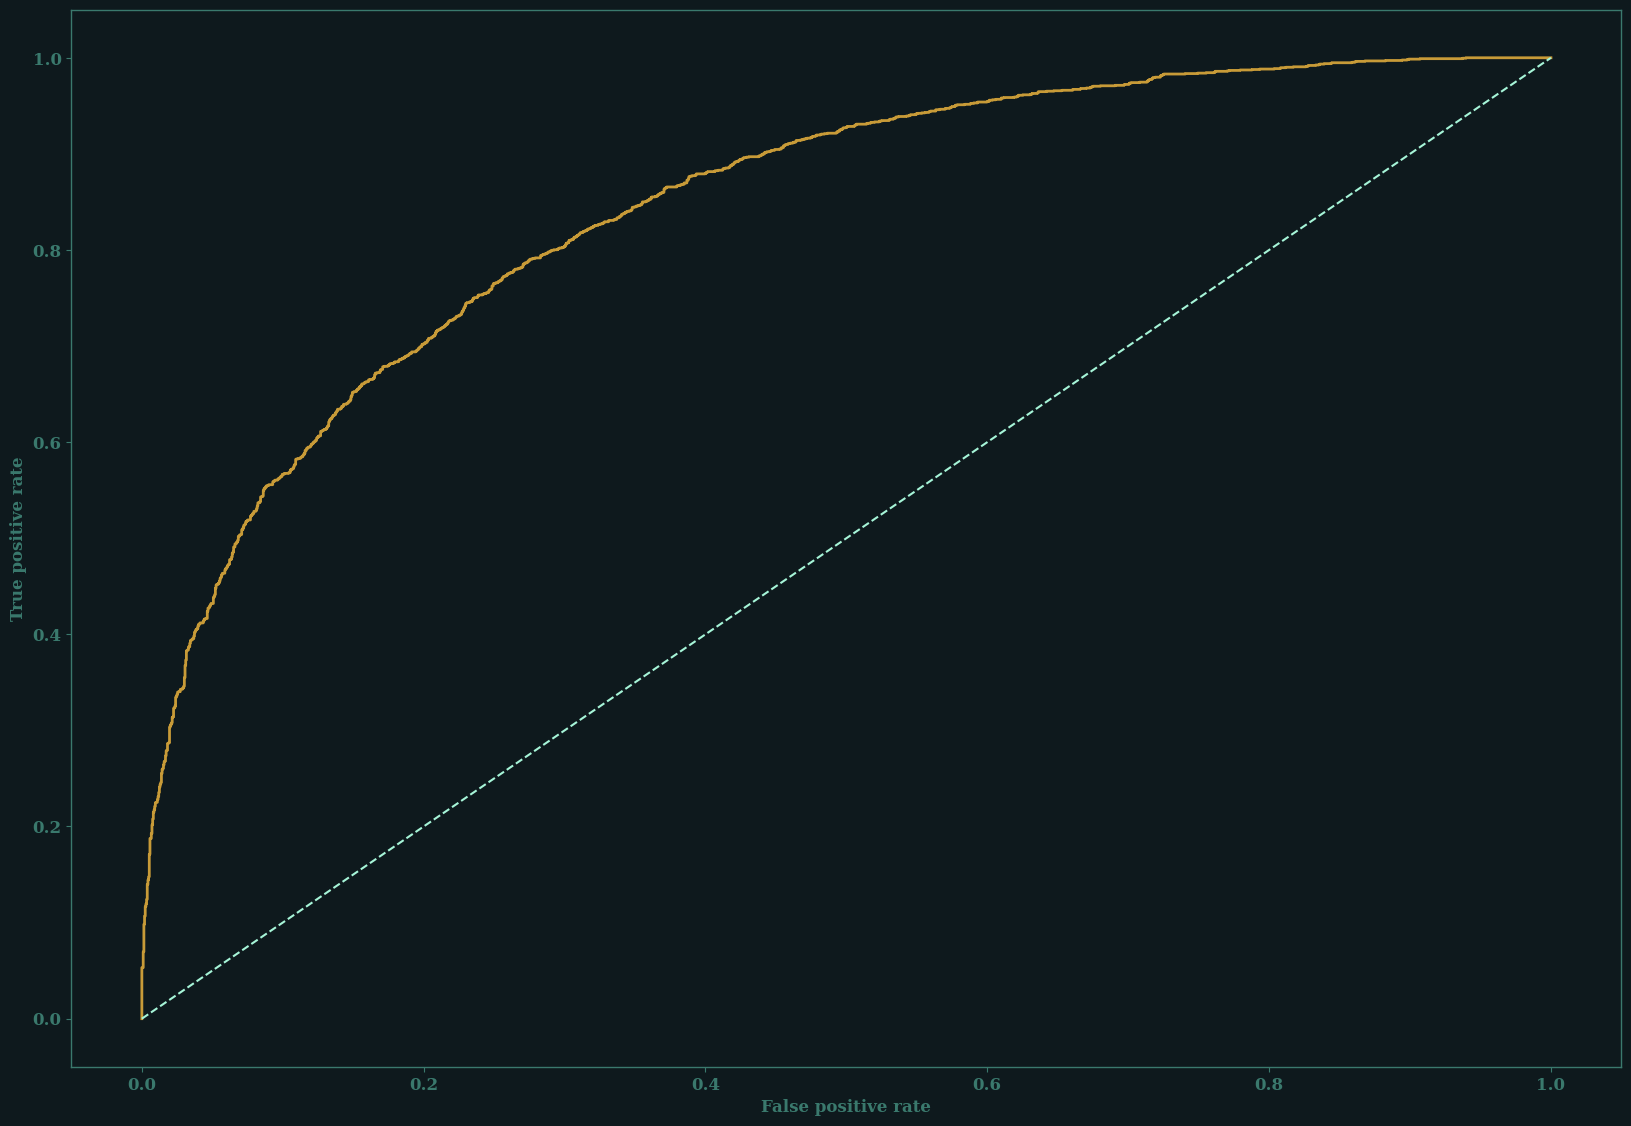

In [88]:
fig2 = plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='#a6f5d8',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title ='ROC curve'
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
plt.rcParams["figure.figsize"]=(20, 14)
fig.set_size_inches(20, 14)
fig.suptitle('ROC Curve')
